## **Análisis Calidad Gasolina - República Dominicana**

**Fecha:** Julio 2024

**Preparado por:** Rafael J. Mateo C.

**Contacto:** rmateo@squalitas.com

### **1. Análisis de los Resultados**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

#### **1.1. Preparación del Análisis**

In [6]:
df = pd.read_parquet('./gas_station_dataset.parquet')

En esta sección nos limitaremos a analizar los datos del RON y MON para las gasolinas del tipo regular y premium. En primer lugar, haremos una copia del dataframe conteniendo solo los datos del RON y MON.

**Limitaciones**: Es importante destacar que este análisis está basado en los resultados de 700 reportes, ya que cerca de 100 presentaron error al procesarse.

In [7]:
df_ron_mon = df[df['ANÁLISIS'].str.contains(r'\(RON\)') | df['ANÁLISIS'].str.contains(r'\(MON\)')].copy()

In [8]:
df_ron_mon.head(5)

,ANÁLISIS,UNIDADES,MIN,MAX,MÉTODO,RESULTADOS,NOMBRE ESTACIÓN,PRODUCTO,FECHA,NUM PAGINA,ARCHIVO,INCERTIDUMBRE/ UNCERTAINTY %,DIRECCIÓN,MARCA ESTACION,OBSERVACIONES,CONFORMIDAD
0,NUMERO DE OCTANO METODO RESEARCH (RON),-,95,-,ASTM D-2699,96.0,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,None,"AIVEPET, S.R.L— REP. DOMINICANA\nReporte Fo...",ATLANTIC,Observación: Valores resaltados se encuentran ...,False
1,NUMERO DE OCTANO METODO MOTOR (MON),.,82,-,ASTM D-2700,87.4,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,None,"AIVEPET, S.R.L— REP. DOMINICANA\nReporte Fo...",ATLANTIC,Observación: Valores resaltados se encuentran ...,False
22,NUMERO DE OCTANO METODO RESEARCH (RON),,95.0,,ASTM D-2699,96.3,ATLANTIC BONAO I (ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,2,2023 07 014.pdf,None,"AIVEPET, S.R.L— REP. DOMINICANA\nReporte Fo...",ATLANTIC,Observación: Valores reportados se encuentran ...,True
23,NUMERO DE OCTANO METODO MOTOR (MON),,82.0,1,ASTM D-2700,87.7,ATLANTIC BONAO I (ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,2,2023 07 014.pdf,None,"AIVEPET, S.R.L— REP. DOMINICANA\nReporte Fo...",ATLANTIC,Observación: Valores reportados se encuentran ...,True
24,NUMERO DE OCTANO METODO RESEARCH (RON),-,89,,ASTM D-2699,91.8,ATLANTIC BONAO I (ANIANA),GASOLINA REGULAR,2023-04-07 15:12:00,3,2023 07 014.pdf,None,"AIVEPET, S.R.L— REP. DOMINICANA\nReporte Fo...",ATLANTIC,Observación: Valores reportados se encuentran ...,True


Ahora nos aseguramos de tener valores en formato número para poder realizar un análisis descriptivo de estos.

In [9]:
df_ron_mon['RESULTADOS'] = df_ron_mon['RESULTADOS'].str.replace(',', '.').replace('N/A', None).astype(float)

In [10]:
df_ron_mon['RESULTADOS'].describe()

count    3772.000000
mean       88.686506
std         5.087323
min        79.500000
25%        84.100000
50%        88.200000
75%        93.800000
max        98.600000
Name: RESULTADOS, dtype: float64

#### **1.2. Análisis Gasolina Premium**

Comencemos el análisis con la gasolina tipo premium. Primero, vamos mostrar las estadísticas descriptivas tanto para el RON como el MON

In [11]:
premium_df = df_ron_mon[df_ron_mon['PRODUCTO'].str.contains('PREMIUM')]

El resumen estadístico del RON muestra que el rango de valores va de 90 a 97.4 para un rango de 7.4. La desviación estándar es de 0.97 y tanto la media como la mediana tienen valores muy similares, lo que significa que existe poca variación en los datos.

Otro punto que puede estacarse es que el 50% de la estaciones tiene un valor de 94.8 hacia abajo, mientras que apenas un 25% tiene un valor por encima de 95.5.

In [12]:
premium_df[premium_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].describe()

count    1004.000000
mean       94.814243
std         0.969930
min        90.800000
25%        94.300000
50%        94.800000
75%        95.500000
max        97.400000
Name: RESULTADOS, dtype: float64

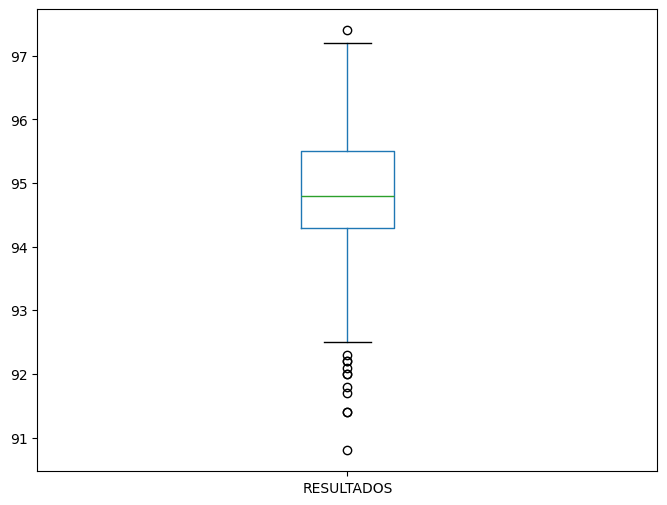

In [13]:
boxplot = premium_df[premium_df['ANÁLISIS'].str.contains('RON')].boxplot(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

A continuación se muestran los valores atípicos identificados en el diagrama de caja anterior

In [14]:
Q1 = premium_df[premium_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].quantile(0.25)
Q3 = premium_df[premium_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = premium_df[premium_df['ANÁLISIS'].str.contains('RON') & ((premium_df['RESULTADOS'] < Q1 - threshold * IQR) |(premium_df['RESULTADOS'] > Q3 + threshold * IQR) )] 

In [15]:
print(outliers[outliers['ANÁLISIS'].str.contains('RON')].groupby('MARCA ESTACION')['RESULTADOS'].apply(list))

MARCA ESTACION
NEXT                                      [90.8]
PETRONAN                            [92.1, 91.8]
SHELL       [92.2, 92.3, 92.0, 91.4, 91.4, 97.4]
TEXACO                              [92.2, 92.0]
TOTAL                                     [91.7]
Name: RESULTADOS, dtype: object


Revisando el histograma de los datos, se observa que está ligeramente sesgado a la izquierda. Este comportamiento es de esperarse por los datos atípicos en el lado izquierdo que se mostraron en la imagen anterior.

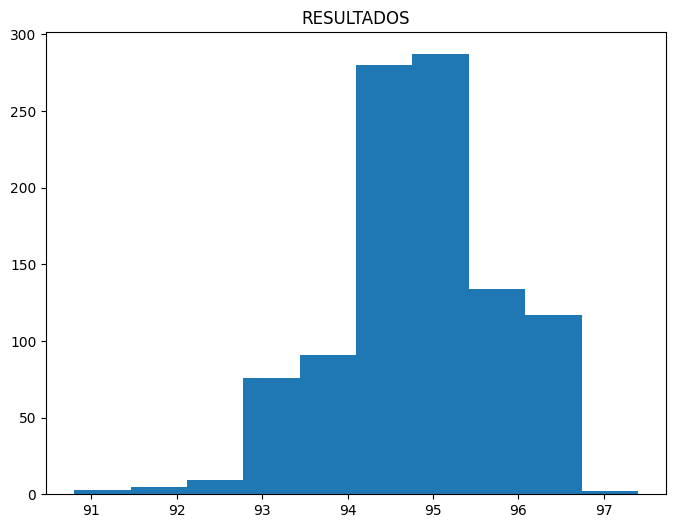

In [16]:
premium_df[premium_df['ANÁLISIS'].str.contains('RON')].hist(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

Al agrupar los datos por estación, podemos observar que las estaciones TOTAL, PETRONAN, NEXT, SOL y UNITED son las que tienen mayor variación en comparación con las demás. Los rangos de valores de estas estaciones van desde 91.7-96.6, 91.8 - 96.5, 90.8 - 96.2, 92.7 - 96.2 y 94.8 - 96.7 respectivamente, siendo NEXT la estación que obtuvo el valor mínimo más bajo (90.8).

Por otro lado, el 75% de las estaciones de AXXON, ESSO, SUNIX y TOTAL tienen un RON por debajo de 95. Por último, solo las estaciones PETROMOVIL, SHELL, TDC y ECOPETROLEO son las que tienen una mediana igual o mayor a 95, lo que indica que el 50% de sus estaciones tienen un RON de 95 o más. En el caso particular de TDC, esta fue la estación con el número mínimo más alto (95.9)

Por último, importante mencionar que el número total de estaciones AXXON, ESSO, SITRAS, TDC y UNITED es menor a 10 en cada una de ellas.

In [17]:
premium_df[premium_df['ANÁLISIS'].str.contains('RON')].groupby('MARCA ESTACION')['RESULTADOS'].describe()

,count,mean,std,min,25%,50%,75%,max
MARCA ESTACION,,,,,,,,
ATLANTIC,13.0,94.823077,0.909353,93.5,94.100,94.80,95.400,96.3
AXXON,6.0,94.650000,0.432435,94.1,94.325,94.70,94.925,95.2
ECOPETROLEO,143.0,95.179021,0.699381,93.4,94.700,95.10,95.500,96.6
ESSO,5.0,94.440000,0.814248,93.5,93.900,94.40,94.800,95.6
EXCOM,42.0,94.964286,0.831930,92.7,94.500,94.90,95.750,96.3
NATIVA,40.0,95.950000,0.432642,94.7,95.900,96.10,96.300,96.6
NEXT,27.0,94.166667,1.192928,90.8,93.250,94.40,95.000,96.2
PETROMOVIL,34.0,95.220588,0.739279,94.2,94.725,95.00,95.925,96.7
PETRONAN,76.0,94.493421,1.043626,91.8,94.000,94.50,95.125,96.5


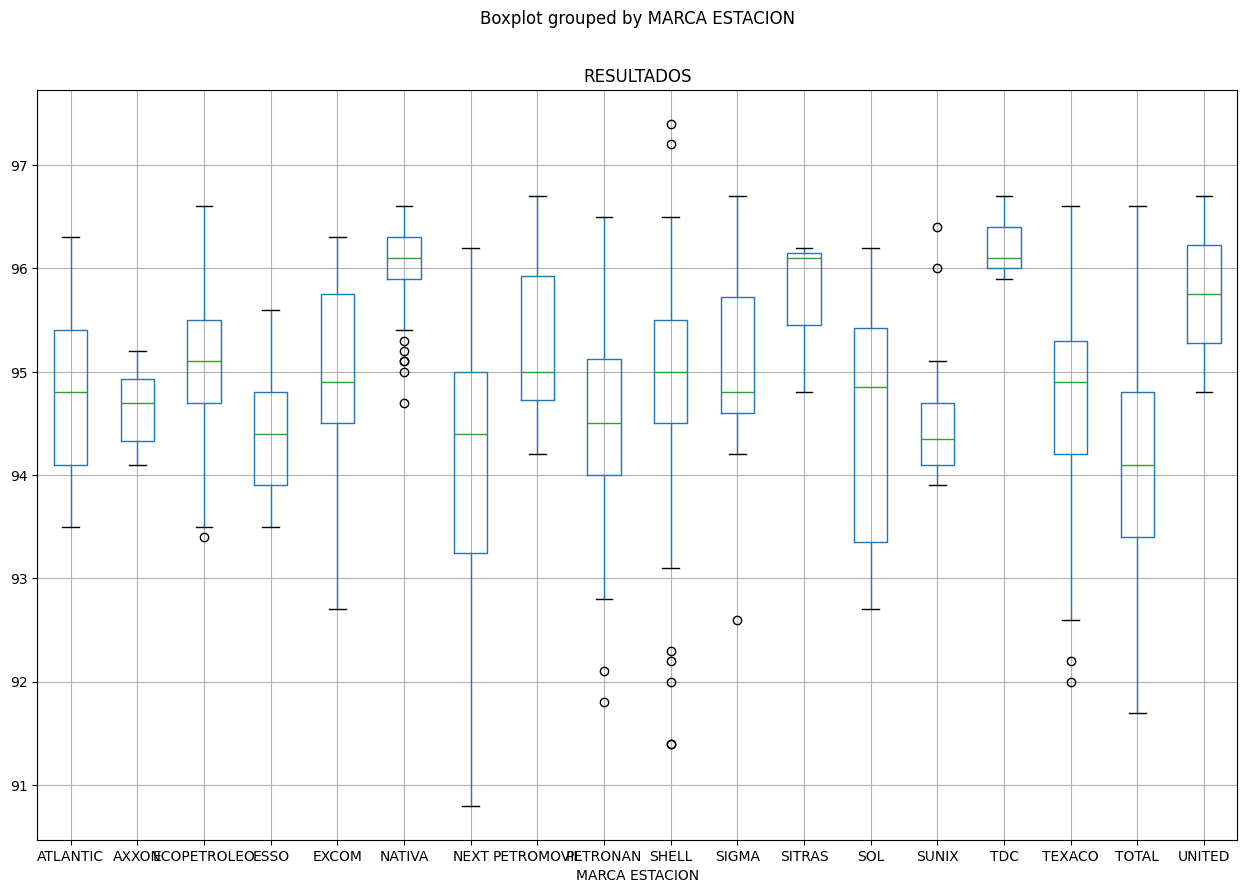

In [18]:
premium_df[premium_df['ANÁLISIS'].str.contains('RON')].boxplot(
    by='MARCA ESTACION',
    column = 'RESULTADOS',
    figsize=(15,10))
plt.show()

Ahora pasamos al análisis de los resultados para el método MON. Como se muestra a continuación, tanto la desviación estándar como el rango es muy similar a los resultados obtenidos por el método RON, lo que sugiere poca variación en los resultados.

In [19]:
premium_df[premium_df['ANÁLISIS'].str.contains('MON')]['RESULTADOS'].describe()

count    994.000000
mean      85.855734
std        1.111920
min       81.800000
25%       85.300000
50%       85.800000
75%       86.400000
max       88.500000
Name: RESULTADOS, dtype: float64

Revisando el diagrama de caja, se muestra una forma ligeramente más simétrica en comparación con los resultados del método RON, aunque si se destaca mayor número de valores atípicos. Lo anterior también puede confirmarse observando el histograma que se muestra más debajo.

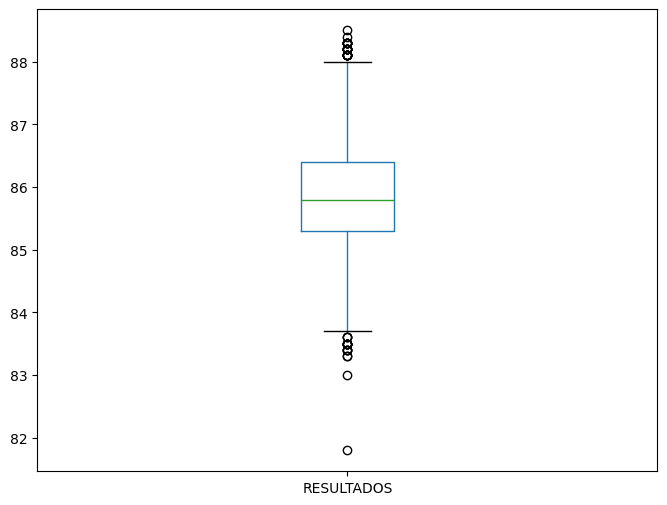

In [20]:
boxplot = premium_df[premium_df['ANÁLISIS'].str.contains('MON')].boxplot(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

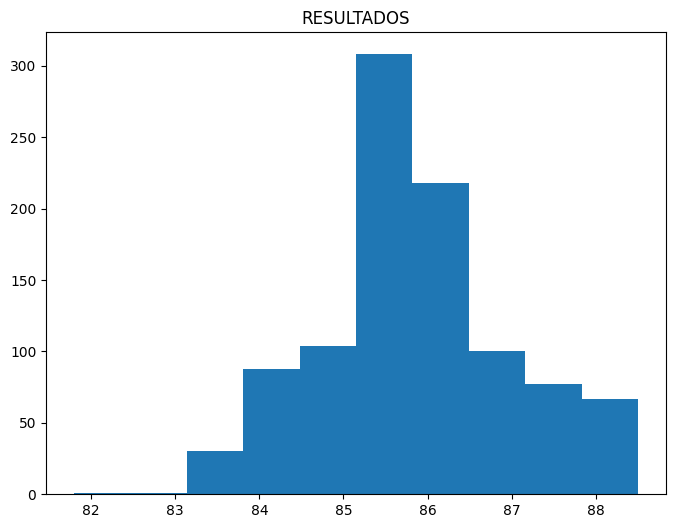

In [21]:
premium_df[premium_df['ANÁLISIS'].str.contains('MON')].hist(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

Como se mencionó arriba, en el caso del método MON, se puede apreciar un mayor número de valores atípicos. Además de las estaciones NEXT, PETRONAN, SHELL, TEXACO y TOTAL, también tienen valores atípicos las estaciones ECOPETROLEO, NATIVA, PETROMOVIL y SIGMA.

In [22]:
Q1 = premium_df[premium_df['ANÁLISIS'].str.contains('MON')]['RESULTADOS'].quantile(0.25)
Q3 = premium_df[premium_df['ANÁLISIS'].str.contains('MON')]['RESULTADOS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = premium_df[premium_df['ANÁLISIS'].str.contains('MON') & ((premium_df['RESULTADOS'] < Q1 - threshold * IQR) |(premium_df['RESULTADOS'] > Q3 + threshold * IQR) )] 

In [23]:
print(outliers[outliers['ANÁLISIS'].str.contains('MON')].groupby('MARCA ESTACION')['RESULTADOS'].apply(list))

MARCA ESTACION
ECOPETROLEO    [88.1, 88.1, 88.3, 88.1, 88.1, 88.2, 88.1, 88....
NATIVA                                        [88.3, 88.1, 88.2]
NEXT                        [83.5, 83.4, 83.4, 83.4, 83.5, 83.0]
PETROMOVIL                        [88.5, 88.3, 88.3, 88.3, 88.2]
PETRONAN                                [88.1, 83.5, 83.5, 83.6]
SHELL                                               [83.5, 81.8]
SIGMA                                                     [88.1]
TEXACO                                              [88.2, 83.6]
TOTAL          [83.4, 83.3, 83.6, 88.2, 83.5, 83.3, 88.4, 88....
Name: RESULTADOS, dtype: object


Realizando el análisis por tipo de estación se puede apreciar que todas las estaciones, a excepción de la SHELL, tienen sus valores por encima de 82, el cual es el valor de referencia mínimo. En cuanto a dispersión de lso datos, las estaciones ATLANTIC, ESSO, NEXT, PETRONAN, TOTAL y UNITED son las que tienen las desviaciones estándares más altas, con un valor igual o mayor a 1.

In [24]:
premium_df[premium_df['ANÁLISIS'].str.contains('MON')].groupby('MARCA ESTACION')['RESULTADOS'].describe()

,count,mean,std,min,25%,50%,75%,max
MARCA ESTACION,,,,,,,,
ATLANTIC,13.0,85.753846,1.023568,84.5,84.900,85.60,86.200,87.7
AXXON,6.0,85.733333,0.344480,85.2,85.525,85.90,85.975,86.0
ECOPETROLEO,144.0,86.398611,0.889094,84.7,85.800,86.20,86.700,88.3
ESSO,4.0,85.375000,1.030776,84.0,85.125,85.50,85.750,86.5
EXCOM,44.0,85.797727,0.975631,83.8,85.200,85.60,86.400,88.0
NATIVA,39.0,87.474359,0.627744,85.9,87.500,87.70,87.900,88.3
NEXT,26.0,85.169231,1.351079,83.0,84.050,85.50,86.075,88.0
PETROMOVIL,34.0,86.505882,0.990238,85.5,85.800,86.10,87.225,88.5
PETRONAN,75.0,85.628000,1.152853,83.5,84.850,85.60,86.150,88.1


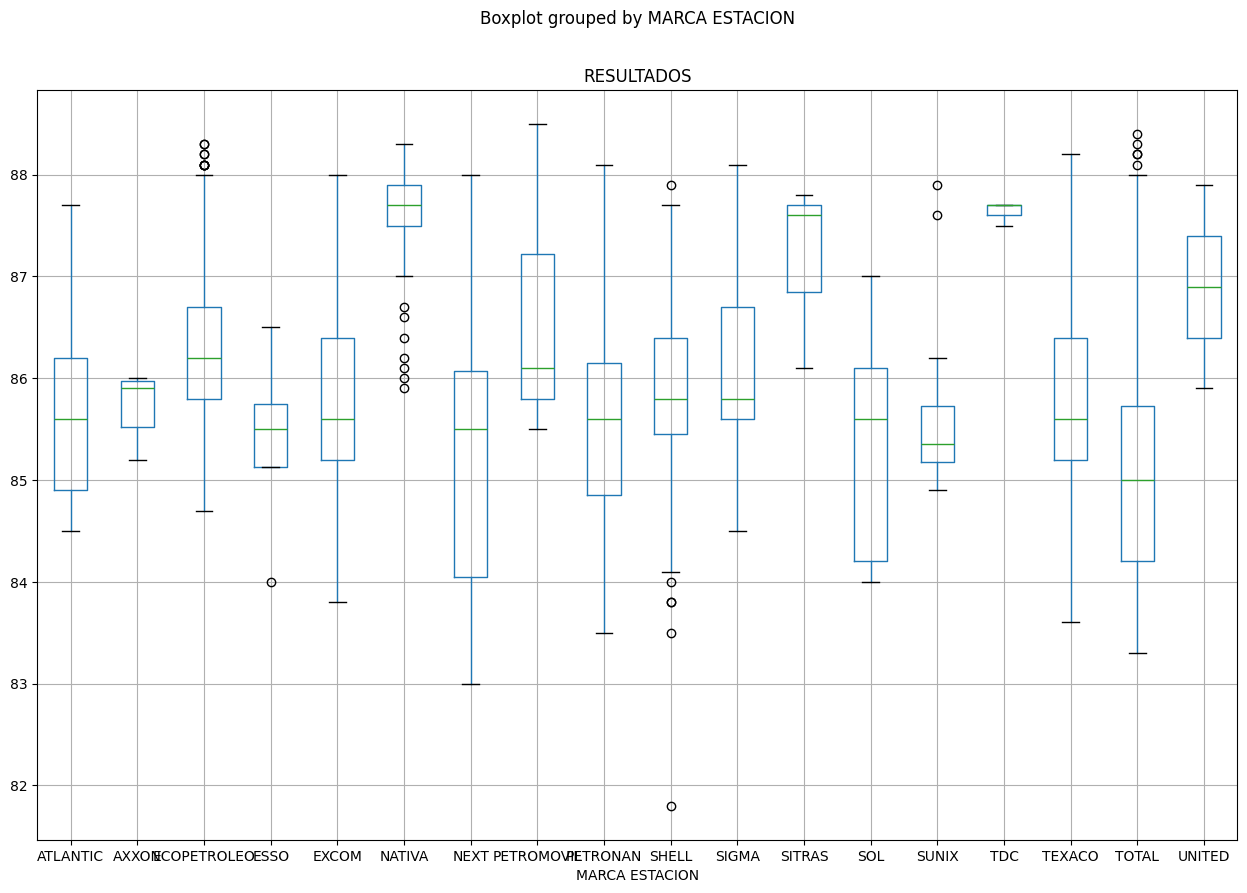

In [25]:
premium_df[premium_df['ANÁLISIS'].str.contains('MON')].boxplot(
    by='MARCA ESTACION',
    column = 'RESULTADOS',
    figsize=(15,10))
plt.show()

#### **1.3. Análisis Gasolina Regular**

Ahora procederemos a realizar el análisis descriptivo para la gasolina de tipo regular. Para esto, creamos primero un dataframe que contenga solo los valores de la gasolina de este tipo.

In [26]:
regular_df = df_ron_mon[df_ron_mon['PRODUCTO'].str.contains('REGULAR')]

Revisando los resultados por el método RON, se aprecia que el 75% de los datos se encuentran por encima del valor 90.4, superior al mínimo de referencia el cual es 89.

In [27]:
regular_df[regular_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].describe()

count    890.000000
mean      91.551461
std        1.720852
min       83.800000
25%       90.400000
50%       91.800000
75%       92.400000
max       98.600000
Name: RESULTADOS, dtype: float64

En el diagrama de caja se puede visualizar menor presencia de valores atípicos, mientras que en el histograma se muestra una distribución centrada. Sin embargo, llama la atención que la mayoría de los valores atípicos se encuentran en el extremo derecho, es decir, con valores que rondan en 95 o más.

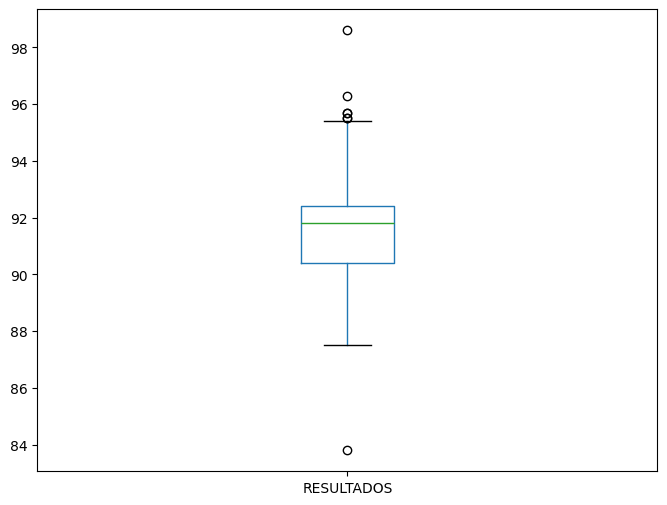

In [28]:
boxplot = regular_df[regular_df['ANÁLISIS'].str.contains('RON')].boxplot(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

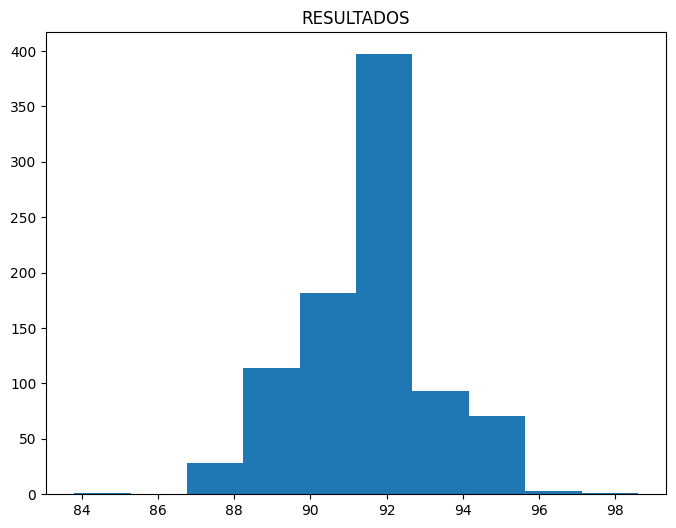

In [29]:
regular_df[regular_df['ANÁLISIS'].str.contains('RON')].hist(column = 'RESULTADOS', figsize=(8,6), grid=False)
plt.show()

Revisando un poco más de cerca los atípicos, se evidencian valores muy por encima del valor mínimo de referencia, el cual es 89. Por ejemplo, TOTAL las Hortensias y SHELL Alvarez presentan valores de 98.6 y 96.3 respectivamente, incluso superior al valor mínimo de referencia de la gasolina Premium.

Estos valores fueron confirmados en el reporte original para descartar cualquier error durante el preprocesamiento de los datos.

In [30]:
Q1 = regular_df[regular_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].quantile(0.25)
Q3 = regular_df[regular_df['ANÁLISIS'].str.contains('RON')]['RESULTADOS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = regular_df[regular_df['ANÁLISIS'].str.contains('RON') & ((regular_df['RESULTADOS'] < Q1 - threshold * IQR) |(regular_df['RESULTADOS'] > Q3 + threshold * IQR) )] 

In [32]:
outliers [['NOMBRE ESTACIÓN', 'RESULTADOS', 'ARCHIVO']]

,NOMBRE ESTACIÓN,RESULTADOS,ARCHIVO
5322,TOTAL HACIENDA,83.8,2023 05 114.pdf
7594,PETROMOVIL JHL HAINA,95.5,2023 02 046.pdf
9022,TOTAL LAS HORTENSIAS,98.6,2023 01 025.pdf
9351,TOTAL LA 27 DE FEBRERO,95.7,2023 03 068.pdf
10047,SHELL ALVAREZ,96.3,2023 07 129.pdf
22614,TOTAL LA ESTRELLA,95.7,2023 02 076.pdf
29024,ECOPETROLEO CAMILO,95.5,2023 05 137.pdf


Realizando el análisis para cada estación, se evidencia que para las estaciones ATLANTIC y SOL cerca del 25% de los resultados caen por debajo de 89. Para las demás, el 75% de los datos son iguales o mayores al valor mínimo de referencia, el cual es de 89.

In [33]:
regular_df[regular_df['ANÁLISIS'].str.contains('RON')].groupby('MARCA ESTACION')['RESULTADOS'].describe()

,count,mean,std,min,25%,50%,75%,max
MARCA ESTACION,,,,,,,,
ATLANTIC,9.0,89.833333,1.081665,88.4,88.900,90.10,90.200,91.8
AXXON,6.0,94.233333,0.939503,92.9,93.650,94.30,94.950,95.3
ECOPETROLEO,118.0,92.475424,1.299568,88.5,91.800,92.20,92.575,95.5
ESSO,3.0,92.200000,0.953939,91.3,91.700,92.10,92.650,93.2
EXCOM,28.0,90.660714,1.780416,87.5,89.175,91.00,91.825,94.0
NATIVA,34.0,92.023529,0.451300,90.6,91.925,92.10,92.300,92.5
NEXT,34.0,91.158824,1.654950,88.6,90.125,90.45,92.475,94.8
PETROMOVIL,32.0,92.381250,1.126925,90.7,91.900,92.05,92.725,95.5
PETRONAN,69.0,91.889855,1.902254,87.9,90.800,91.90,93.200,95.4


Revisando más de cerca los datos para cada estación por medio del diagrama de caja, se puede apreciar un mayor número de valores atípicos en el extremo derecho, siendo estos por lo general igual o superior a 94.

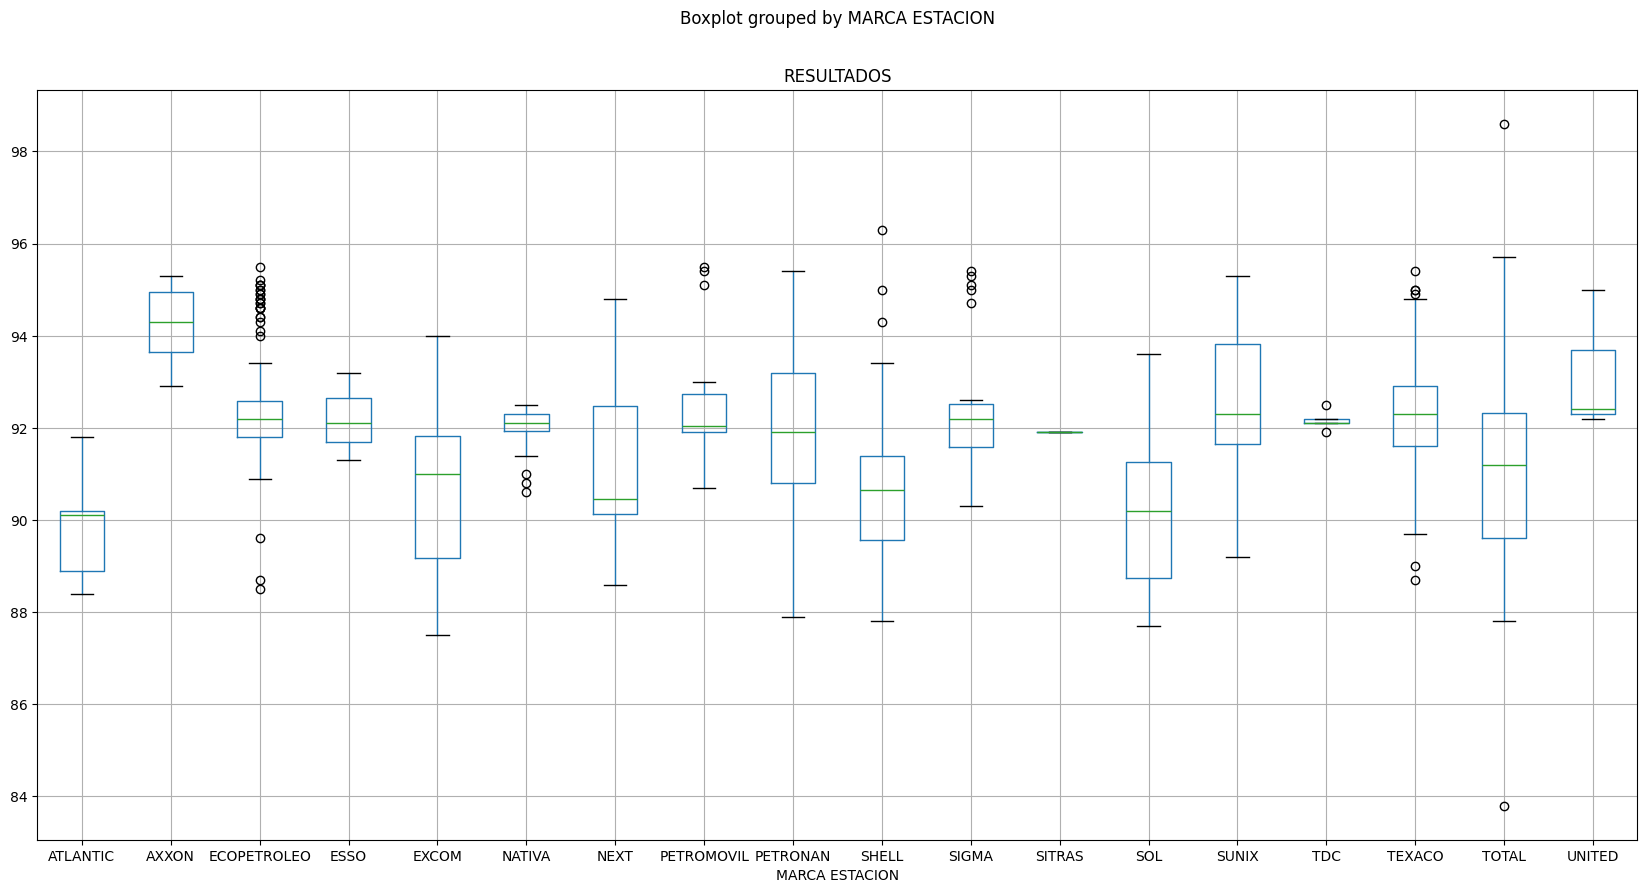

In [38]:
regular_df[regular_df['ANÁLISIS'].str.contains('RON')].boxplot(
    by='MARCA ESTACION',
    column = 'RESULTADOS',
    figsize=(20,10))
plt.show()

Filtrando todos los valores mayores o iguales a 95 del método RON para la gasolina regular, se obtienen un total de 29 registros. Como se mencionó más arriba, llama la atención que el valor obtenido en esas estaciones para la gasolina regular sea mayor o igual al valor mínimo de referencia para la gasolina premium.

In [40]:
ron_regular_df = regular_df[regular_df['ANÁLISIS'].str.contains('RON')]
ron_regular_df[ron_regular_df['RESULTADOS'] >= 95][['NOMBRE ESTACIÓN', 'MARCA ESTACION', 'ANÁLISIS','RESULTADOS', 'ARCHIVO']]

,NOMBRE ESTACIÓN,MARCA ESTACION,ANÁLISIS,RESULTADOS,ARCHIVO
809,TEXACO SAN ANDRES,TEXACO,NUMERO DE OCTANO METODO RESEARCH (RON),95.0,2023 02 025.pdf
4048,SIGMA AV. ECOLOGICA,SIGMA,NUMERO DE OCTANO METODO RESEARCH (RON),95.3,2023 02 037.pdf
4440,TEXACO MOCA,TEXACO,NUMERO DE OCTANO METODO RESEARCH (RON),95.4,2023 03 033.pdf
5160,SHELL JUANA RUIZ,SHELL,NUMERO DE OCTANO METODO RESEARCH (RON),95.0,2023 01 040.pdf
6063,ECOPETROLEO SATELITE,ECOPETROLEO,NUMERO DE OCTANO METODO RESEARCH (RON),95.2,2023 02 009.pdf
6085,ECOPETROLEO SATELITE,ECOPETROLEO,NUMERO DE OCTANO METODO RESEARCH (RON),95.1,2023 02 009.pdf
6362,PETROMOVIL ROMAR,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.4,2023 03 030.pdf
6385,PETROMOVIL ROMAR,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.1,2023 03 030.pdf
6874,SUNIX GENESIS,SUNIX,NUMERO DE OCTANO METODO RESEARCH (RON),95.3,2023 01 082.pdf
7594,PETROMOVIL JHL HAINA,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.5,2023 02 046.pdf


Realizando un conteo por estación, la estación ECOPETROLEO es la que cuenta con un mayor número de resultados igual o mayor a 95.

In [41]:
ron_regular_df[ron_regular_df['RESULTADOS'] >= 95][['MARCA ESTACION']].value_counts()

MARCA ESTACION
ECOPETROLEO       7
SIGMA             4
PETROMOVIL        3
PETRONAN          3
TEXACO            3
TOTAL             3
AXXON             2
SHELL             2
SUNIX             1
UNITED            1
Name: count, dtype: int64

El número de estaciones aumenta considerablemente si se filtran los valores para un RON mayor o igual a 94.

In [43]:
ron_regular_df[ron_regular_df['RESULTADOS'] >= 94][['MARCA ESTACION']].value_counts()

MARCA ESTACION
ECOPETROLEO       23
TEXACO            15
PETRONAN          14
TOTAL             12
SIGMA              5
SUNIX              4
AXXON              3
NEXT               3
PETROMOVIL         3
SHELL              3
EXCOM              1
UNITED             1
Name: count, dtype: int64

### **2. Conclusiones**

Este análisis se enfocó solamente para los valores RON de la gasolina premium y regular, así como los valores MON para la gasolina premium. Los datos utilizados fueron extraidos directamente de los informes a través del servicio Document Intelligence de Azure. Un total de 100 archivos no pudieron ser procesados, por lo que queda pendiente de su revisión para evaluar la posibilidad de resolver los errores e incorporar los datos de esos reportes al análisis.

En cuanto a los resultados del análisis, para la gasolina premium se aprecia poca variación en los datos lo que implica que su calidad es consistente. Sin embargo, para una gran cantidad de estaciones, la media se encuentra fuera del rango de los valores mínimos establecidos. Por ejemplo, para el método RON, cerca del 50% de los datos se encuentran por debajo de 95.

Respecto a la gasolina regular, también se evidencia consistencia en sus valores, aunque en menor medida. Algunos hallazgos llaman la atención, como por ejemplo el hecho de que varios resultados por el método RON se encuentran igual o por encima de 95, valor mínimo establecido para la gasolina premium.